In [1]:
import argparse
import time
from utils import misc
import torch
from torch.autograd import Variable
from datetime import datetime
import numpy as np
from model import DAE_C, DAE_F
import train
from source_separation import MFA
from dataset.HLsep_dataloader import hl_dataloader, val_dataloader
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt 
import librosa,scipy
from matplotlib.ticker import MaxNLocator

In [2]:
_DRAW_SOFTMAX = True
_DRAW_FFT = True

In [3]:
# parser: argparse.ArgumentParser 在 jupyter notebook 不能使用因為 parser.parse_args() 
# 要求 sys.argv 要是 ['']，but jupyter notebook 預設並不是空。

# 以下是 parser 替代方案: 使用 http://35.192.144.192:8000/arg2cls.html 做轉換

class Args:
  model_type = 'DAE_C'
  data_feature = 'lps'
  pretrained = False
  pretrained_path = None
  trainOrtest = 'train'
  optim = 'Adam'
  batch_size = 32
  lr = 1e-4
  CosineAnnealingWarmRestarts = False
  epochs = 50
  grad_scale = 8
  seed = 117
  log_interval = 100
  test_interval = 1
  logdir = 'log/fjp/'
  decreasing_lr = '200,250'
  source_num = 3
  clustering_alg = 'NMF'
  wienner_mask = True

args=Args()

In [4]:
args.cuda = torch.cuda.is_available()
args.cuda

True

In [5]:
logger = None # jupyter notebook 不須用

In [6]:
# build model
decreasing_lr = list(map(int, args.decreasing_lr.split(',')))
best_acc, old_file = 0, None
per_save_epoch = 30
t_begin = time.time()
grad_scale = args.grad_scale
# model dictionary
DAE_C_dict = {
        "frequency_bins": [0, 300],
        "encoder": [32, 16, 8],
        "decoder": [8, 16, 32, 1],
        "encoder_filter": [[1, 3], [1, 3], [1, 3]],
        "decoder_filter": [[1, 3], [1, 3], [1, 3], [1, 1]],
        "encoder_act": "relu",
        "decoder_act": "relu",
        "dense": [],
        }
DAE_F_dict = {
        "frequency_bins": [0, 300],
        "encoder": [1024, 512, 256, 128],
        "decoder": [256, 512, 1024, 1025],
        "encoder_act": "relu",
        "decoder_act": "relu",
        }

Model = {
    'DAE_C': DAE_C.autoencoder,
    'DAE_F': DAE_F.autoencoder,
}

model_dict = {
    'DAE_C': DAE_C_dict,
    'DAE_F': DAE_F_dict
}
FFT_dict = {
    'sr': 8000,
    'frequency_bins': [0, 300],
    'FFTSize': 2048,
    'Hop_length': 128,
    'Win_length': 2048,
    'normalize': True,
}

In [7]:
# declare model
net = Model[args.model_type](model_dict=model_dict[args.model_type], args=args, logger=logger).cuda()

# 用已經練好的
# net.load_state_dict(torch.load('./log/fjp/latest.pth'))

In [8]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    net.cuda()

In [9]:
# data loader
test_filelist = ["./filtered_wav/209_pure_lung_16bit.wav"]
test_filename = "209_pure_lung"
outdir = "{0}/lung_".format(args.logdir)
train_loader = hl_dataloader(test_filelist, batch_size=args.batch_size, shuffle=True, num_workers=0, pin_memory=True, FFT_dict=FFT_dict, args=args)


In [10]:
# train
net = train.train(train_loader, net, args, logger)

epoch0:1.0465086698532104
epoch1:1.0426926612854004
epoch2:1.0353162288665771
epoch3:1.0198452472686768
epoch4:0.9891474843025208
epoch5:0.9319753050804138
epoch6:0.8275030851364136
epoch7:0.6501307487487793
epoch8:0.48001664876937866
epoch9:0.42678993940353394
epoch10:0.406403124332428
epoch11:0.3830661177635193
epoch12:0.34959641098976135
epoch13:0.3060995936393738
epoch14:0.25389203429222107
epoch15:0.19793197512626648
epoch16:0.15076053142547607
epoch17:0.12136135995388031
epoch18:0.10836844891309738
epoch19:0.10055441409349442
epoch20:0.09509476274251938
epoch21:0.09068591147661209
epoch22:0.08698819577693939
epoch23:0.08384691178798676
epoch24:0.08113597333431244
epoch25:0.07874999195337296
epoch26:0.07660216838121414
epoch27:0.0745820626616478
epoch28:0.07191982120275497
epoch29:0.06899687647819519
epoch30:0.06658418476581573
epoch31:0.06459752470254898
epoch32:0.06268245726823807
epoch33:0.06077102571725845
epoch34:0.05883508548140526
epoch35:0.05689272657036781
epoch36:0.05498

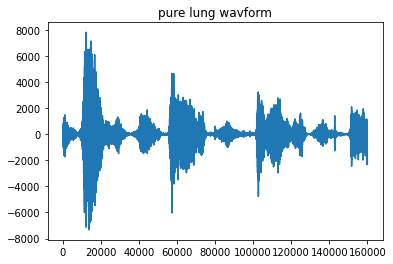

In [11]:
rate, y = wav.read(test_filelist[0])
plt.title("pure lung wavform")
plt.plot(y);

In [25]:
# Source Separation by MFA analysis.
mfa = MFA.MFA_source_separation(net, FFT_dict=FFT_dict, args=args)
for test_file in test_filelist:
    # load test data
    lps, phase, mean, std = val_dataloader(test_file, FFT_dict)
    mfa.source_separation(np.array(lps), np.array(phase), np.array(mean), np.array(std), filedir=outdir, filename=test_filename)


In [13]:
s = {'lps':None,
    'phase':None,
    'mean':None,
    'std':None}
s['lps'], s['phase'], s['mean'], s['std']  = val_dataloader(test_filelist[0], FFT_dict)

In [14]:
test_dataloader = hl_dataloader(test_filelist, batch_size=args.batch_size, shuffle=False, num_workers=0, pin_memory=True, FFT_dict=FFT_dict, args=args)

In [15]:
for frame in test_dataloader:
    frame = frame.detach().clone().type(torch.float)
    latent_output = net.encoder(frame.cuda())

In [16]:
latent_output.shape

torch.Size([19, 2400])

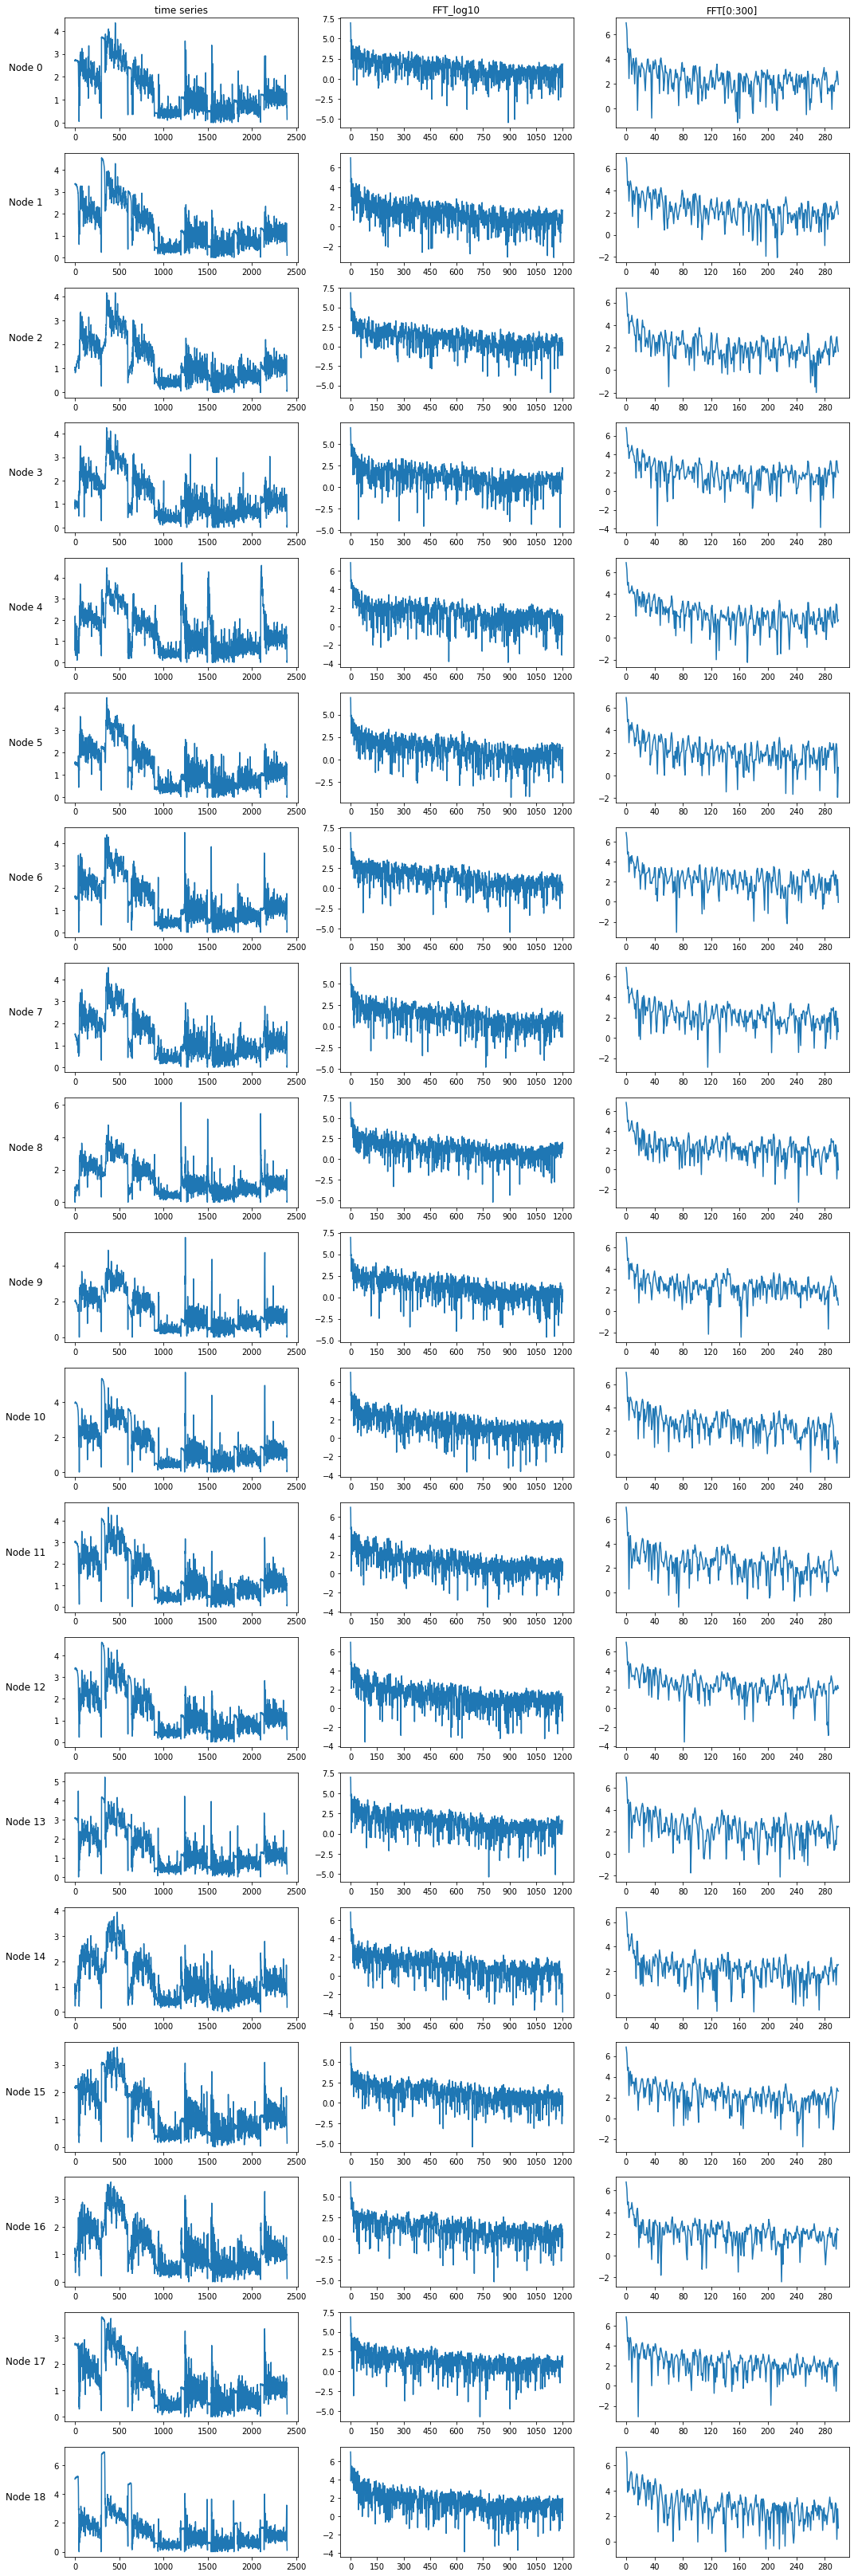

In [16]:
if (_DRAW_FFT):
    fig, axs = plt.subplots(latent_output.shape[0], 3)
    fig.set_figheight(45)
    fig.set_figwidth(15)

    cols_title = ['time series', 'FFT_log10', 'FFT[0:300]']
    rows = ['Node {}'.format(row) for row in range(latent_output.shape[0])]

frame_num = latent_output.shape[1]
fft_result = []

epsilon = np.finfo(float).eps
for i in range(latent_output.shape[0]):
    # origin time-series
    ts = latent_output[i].detach().cpu()
    # fft
    fft_ = librosa.stft(ts[:].numpy(), n_fft=frame_num, hop_length=frame_num+1, window=scipy.signal.hamming)
    fft_ = fft_+ epsilon
    fft_ = abs(fft_)**2
    log10_fft_ = np.log10(fft_)
    
    # 紀錄 log10 後的 fft 結果
    fft_result.append(log10_fft_)
    
    if (_DRAW_FFT):
        axs[i, 0].plot(ts)
        axs[i, 1].plot(log10_fft_)
        axs[i, 2].plot(log10_fft_[FFT_dict['frequency_bins'][0]:FFT_dict['frequency_bins'][1]])
#====================
if (_DRAW_FFT):
    for ax in axs[:,1]:
        xa = ax.get_xaxis()
        xa.set_major_locator(MaxNLocator(integer=True))

    for ax in axs[:,2]:
        xa = ax.get_xaxis()
        xa.set_major_locator(MaxNLocator(integer=True))

    for ax, col in zip(axs[0,:], cols_title):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel(row,labelpad = 35, rotation=0, size='large')
#====================   
fft_result = np.array(fft_result)
fft_result = np.squeeze(fft_result)
fig.tight_layout()

In [18]:
partial_fft_ = fft_result[:,FFT_dict['frequency_bins'][0]:FFT_dict['frequency_bins'][1]]

smooth_fft = scipy.signal.savgol_filter(partial_fft_, window_length=5,polyorder=2)

# log_10(FFT) 的結果丟進去 softmax，lung 分布 
lung_logscale_softmax = scipy.special.softmax(partial_fft_,axis=1)
lung_smooth_softmax = scipy.special.softmax(smooth_fft,axis=1)

__lung_data__ = {"logscale_softmax":lung_logscale_softmax,
                 "smooth_softmax":lung_smooth_softmax}

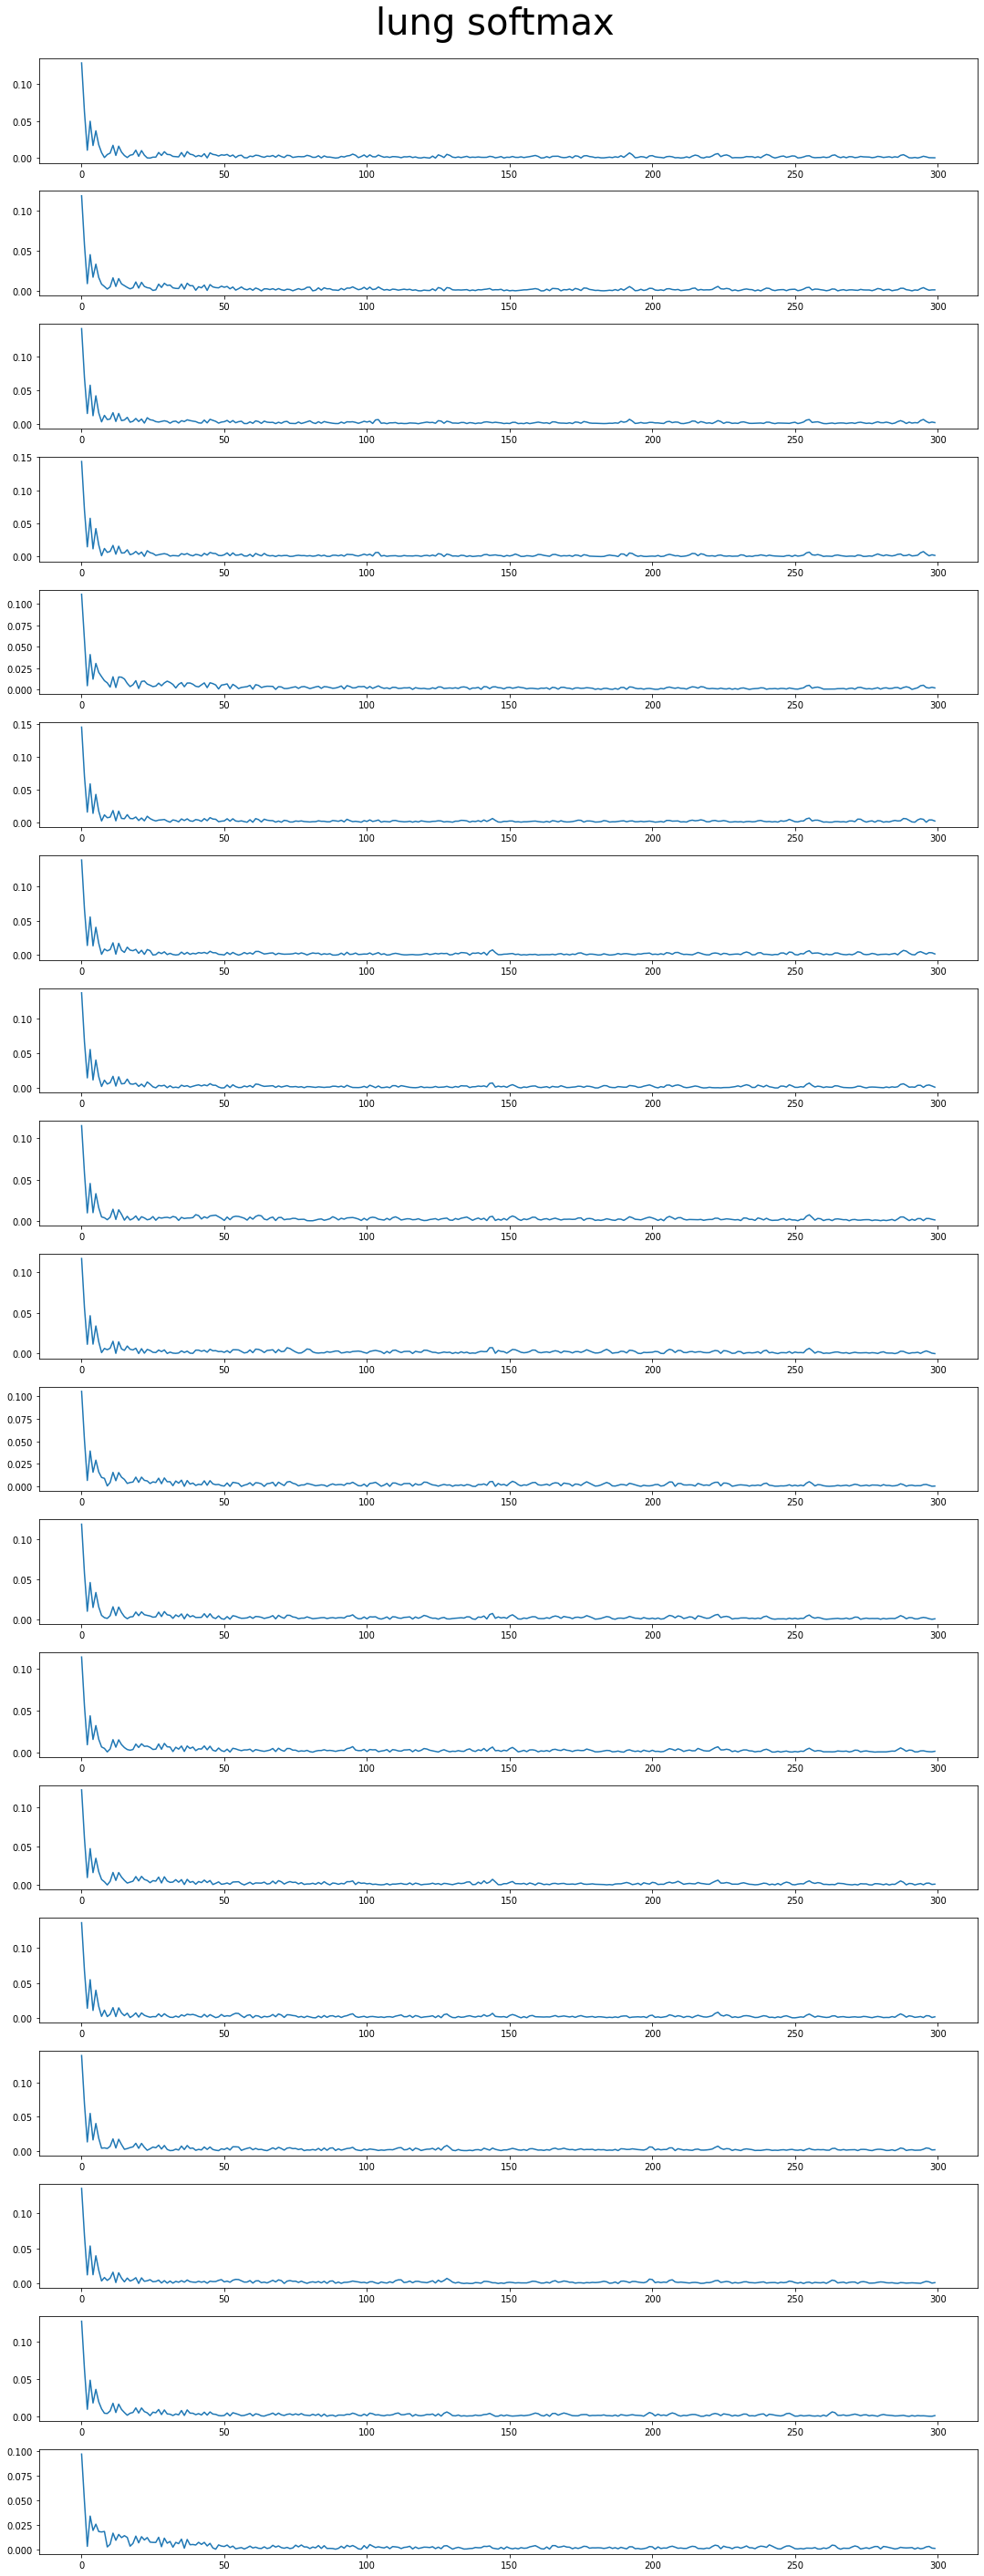

In [19]:
if (_DRAW_SOFTMAX):
    # 畫出分布
    draw_target_ = lung_logscale_softmax

    fig, axs = plt.subplots(draw_target_.shape[0])

    fig.set_figheight(40)
    fig.set_figwidth(15)

    for i in range(draw_target_.shape[0]):
        axs[i].plot(draw_target_[i][:])
    fig.suptitle("lung softmax",size=40)
    fig.tight_layout()
    fig.subplots_adjust(top=0.96)

In [20]:
#=========================  以下心音 ================================

In [21]:
# 取得一個 net
net = Model[args.model_type](model_dict=model_dict[args.model_type], args=args, logger=logger).cuda()
# 固定隨機種子
torch.manual_seed(args.seed)
# 是否轉移 net 至 cuda
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    net.cuda()
# data loader
test_filelist = ["./filtered_wav/123_pure_heart_manul_16bit.wav"]
test_filename = "123_pure_heart"
outdir = "{0}/lung_".format(args.logdir)
train_loader = hl_dataloader(test_filelist, batch_size=args.batch_size, shuffle=True, num_workers=0, pin_memory=True, FFT_dict=FFT_dict, args=args)
# train
net = train.train(train_loader, net, args, logger)
# test
for batch_idx, data in enumerate(train_loader):
    if args.cuda:
        data = data.cuda().float()
    data = Variable(data)
    output = net(data)
    output_ = torch.reshape(output, (-1,)).detach().cpu()
output_ = output_.numpy()

D:\git-repo\qpzm_MFA_DAE\src\utils\signalprocess.py:35: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, y = wav.read(y)


epoch0:1.0289227962493896
epoch1:1.0261292457580566
epoch2:1.022847294807434
epoch3:1.0191065073013306
epoch4:1.012242078781128
epoch5:0.9987705945968628
epoch6:0.9680331349372864
epoch7:0.8790326714515686
epoch8:0.7144997715950012
epoch9:0.4949445128440857
epoch10:0.2614300549030304
epoch11:0.13267454504966736
epoch12:0.10783751308917999
epoch13:0.10249973833560944
epoch14:0.09917137026786804
epoch15:0.09636492282152176
epoch16:0.09359387308359146
epoch17:0.09079067409038544
epoch18:0.08793511241674423
epoch19:0.08501087129116058
epoch20:0.08214235305786133
epoch21:0.07927656173706055
epoch22:0.07648305594921112
epoch23:0.0738501027226448
epoch24:0.07112952321767807
epoch25:0.06858669221401215
epoch26:0.06643752008676529
epoch27:0.06457855552434921
epoch28:0.06293675303459167
epoch29:0.061547767370939255
epoch30:0.06036173179745674
epoch31:0.05931289494037628
epoch32:0.05834280326962471
epoch33:0.05742678418755531
epoch34:0.05647854506969452
epoch35:0.055557966232299805
epoch36:0.0546

f:\users\mslab\anaconda3\envs\anicca\lib\site-packages\ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


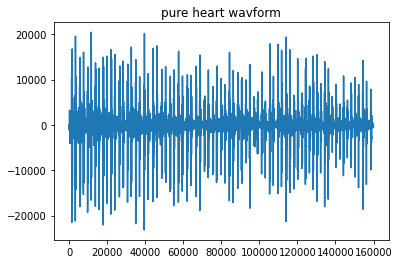

In [22]:
rate, y = wav.read(test_filelist[0])
plt.title("pure heart wavform")
plt.plot(y);

In [23]:
# Source Separation by MFA analysis.
mfa = MFA.MFA_source_separation(net, FFT_dict=FFT_dict, args=args)
for test_file in test_filelist:
    # load test data
    lps, phase, mean, std = val_dataloader(test_file, FFT_dict)
    mfa.source_separation(np.array(lps), np.array(phase), np.array(mean), np.array(std), filedir=outdir, filename=test_filename)

D:\git-repo\qpzm_MFA_DAE\src\utils\signalprocess.py:35: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, y = wav.read(y)


In [24]:
s = {'lps':None,
    'phase':None,
    'mean':None,
    'std':None}
s['lps'], s['phase'], s['mean'], s['std']  = val_dataloader(test_filelist[0], FFT_dict)

In [25]:
test_dataloader = hl_dataloader(test_filelist, batch_size=args.batch_size, shuffle=False, num_workers=0, pin_memory=True, FFT_dict=FFT_dict, args=args)

for frame in test_dataloader:
    #frame = torch.tensor(frame,dtype=torch.float,device='cuda')
    frame = frame.detach().clone().type(torch.float)
    latent_output = net.encoder(frame.cuda())

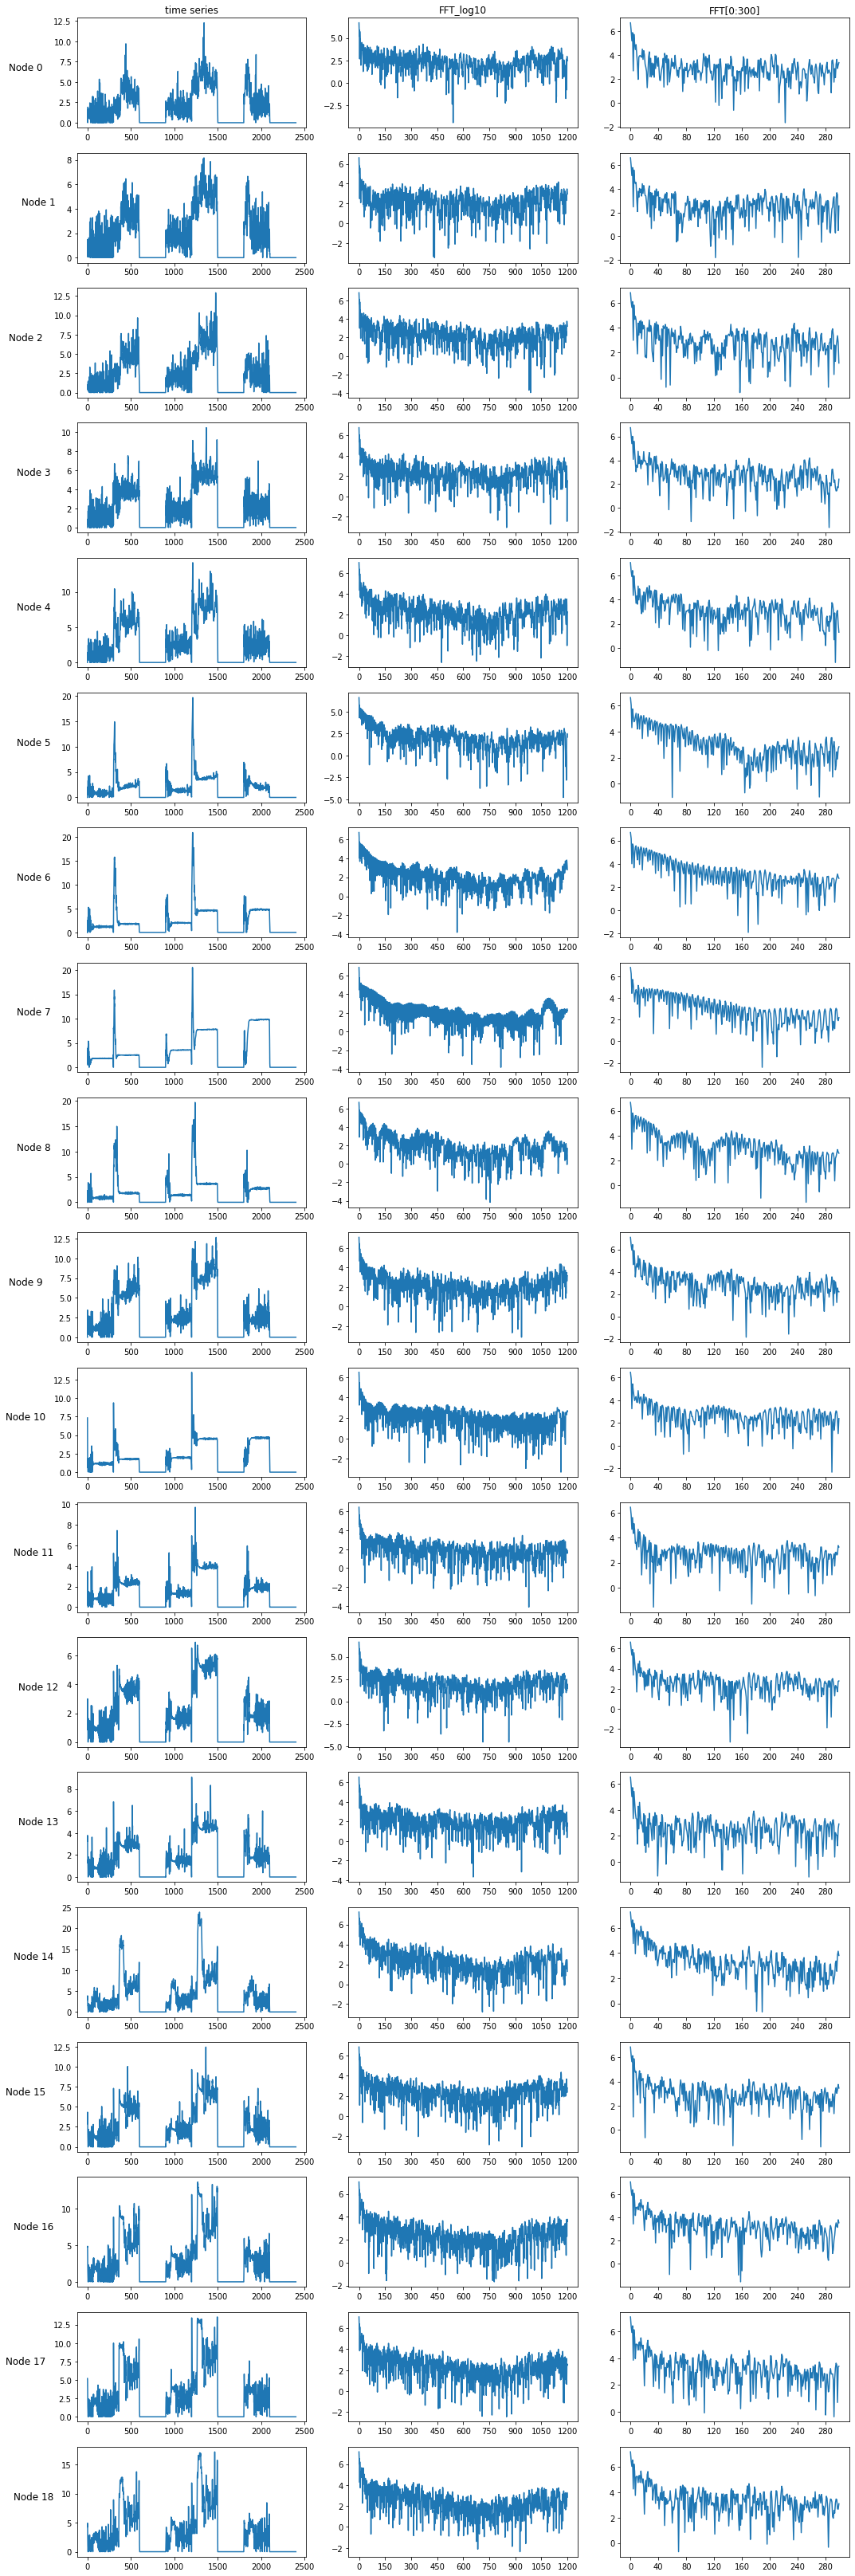

In [26]:
if (_DRAW_FFT):
    fig, axs = plt.subplots(latent_output.shape[0], 3)
    fig.set_figheight(45)
    fig.set_figwidth(15)

    cols_title = ['time series', 'FFT_log10', 'FFT[0:300]']
    rows = ['Node {}'.format(row) for row in range(latent_output.shape[0])]

frame_num = latent_output.shape[1]
fft_result = []

epsilon = np.finfo(float).eps
for i in range(latent_output.shape[0]):
    # origin time-series
    ts = latent_output[i].detach().cpu()
    # fft
    fft_ = librosa.stft(ts[:].numpy(), n_fft=frame_num, hop_length=frame_num+1, window=scipy.signal.hamming)
    fft_ = fft_+ epsilon
    fft_ = abs(fft_)**2
    log10_fft_ = np.log10(fft_)
    
    # 紀錄 log10 後的 fft 結果
    fft_result.append(log10_fft_)
    
    if (_DRAW_FFT):
        axs[i, 0].plot(ts)
        axs[i, 1].plot(log10_fft_)
        axs[i, 2].plot(log10_fft_[FFT_dict['frequency_bins'][0]:FFT_dict['frequency_bins'][1]])
#====================
if (_DRAW_FFT):
    for ax in axs[:,1]:
        xa = ax.get_xaxis()
        xa.set_major_locator(MaxNLocator(integer=True))

    for ax in axs[:,2]:
        xa = ax.get_xaxis()
        xa.set_major_locator(MaxNLocator(integer=True))

    for ax, col in zip(axs[0,:], cols_title):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel(row,labelpad = 35, rotation=0, size='large')
#====================   
fft_result = np.array(fft_result)
fft_result = np.squeeze(fft_result)
fig.tight_layout()

In [27]:
partial_fft_ = fft_result[:,FFT_dict['frequency_bins'][0]:FFT_dict['frequency_bins'][1]]

smooth_fft = scipy.signal.savgol_filter(partial_fft_, window_length=5,polyorder=2)

# log_10(FFT) 的結果丟進去 softmax，heart 分布 
heart_logscale_softmax = scipy.special.softmax(partial_fft_,axis=1)
heart_smooth_softmax = scipy.special.softmax(smooth_fft,axis=1)

__heart_data__ = {"logscale_softmax":heart_logscale_softmax,
                 "smooth_softmax":heart_smooth_softmax}

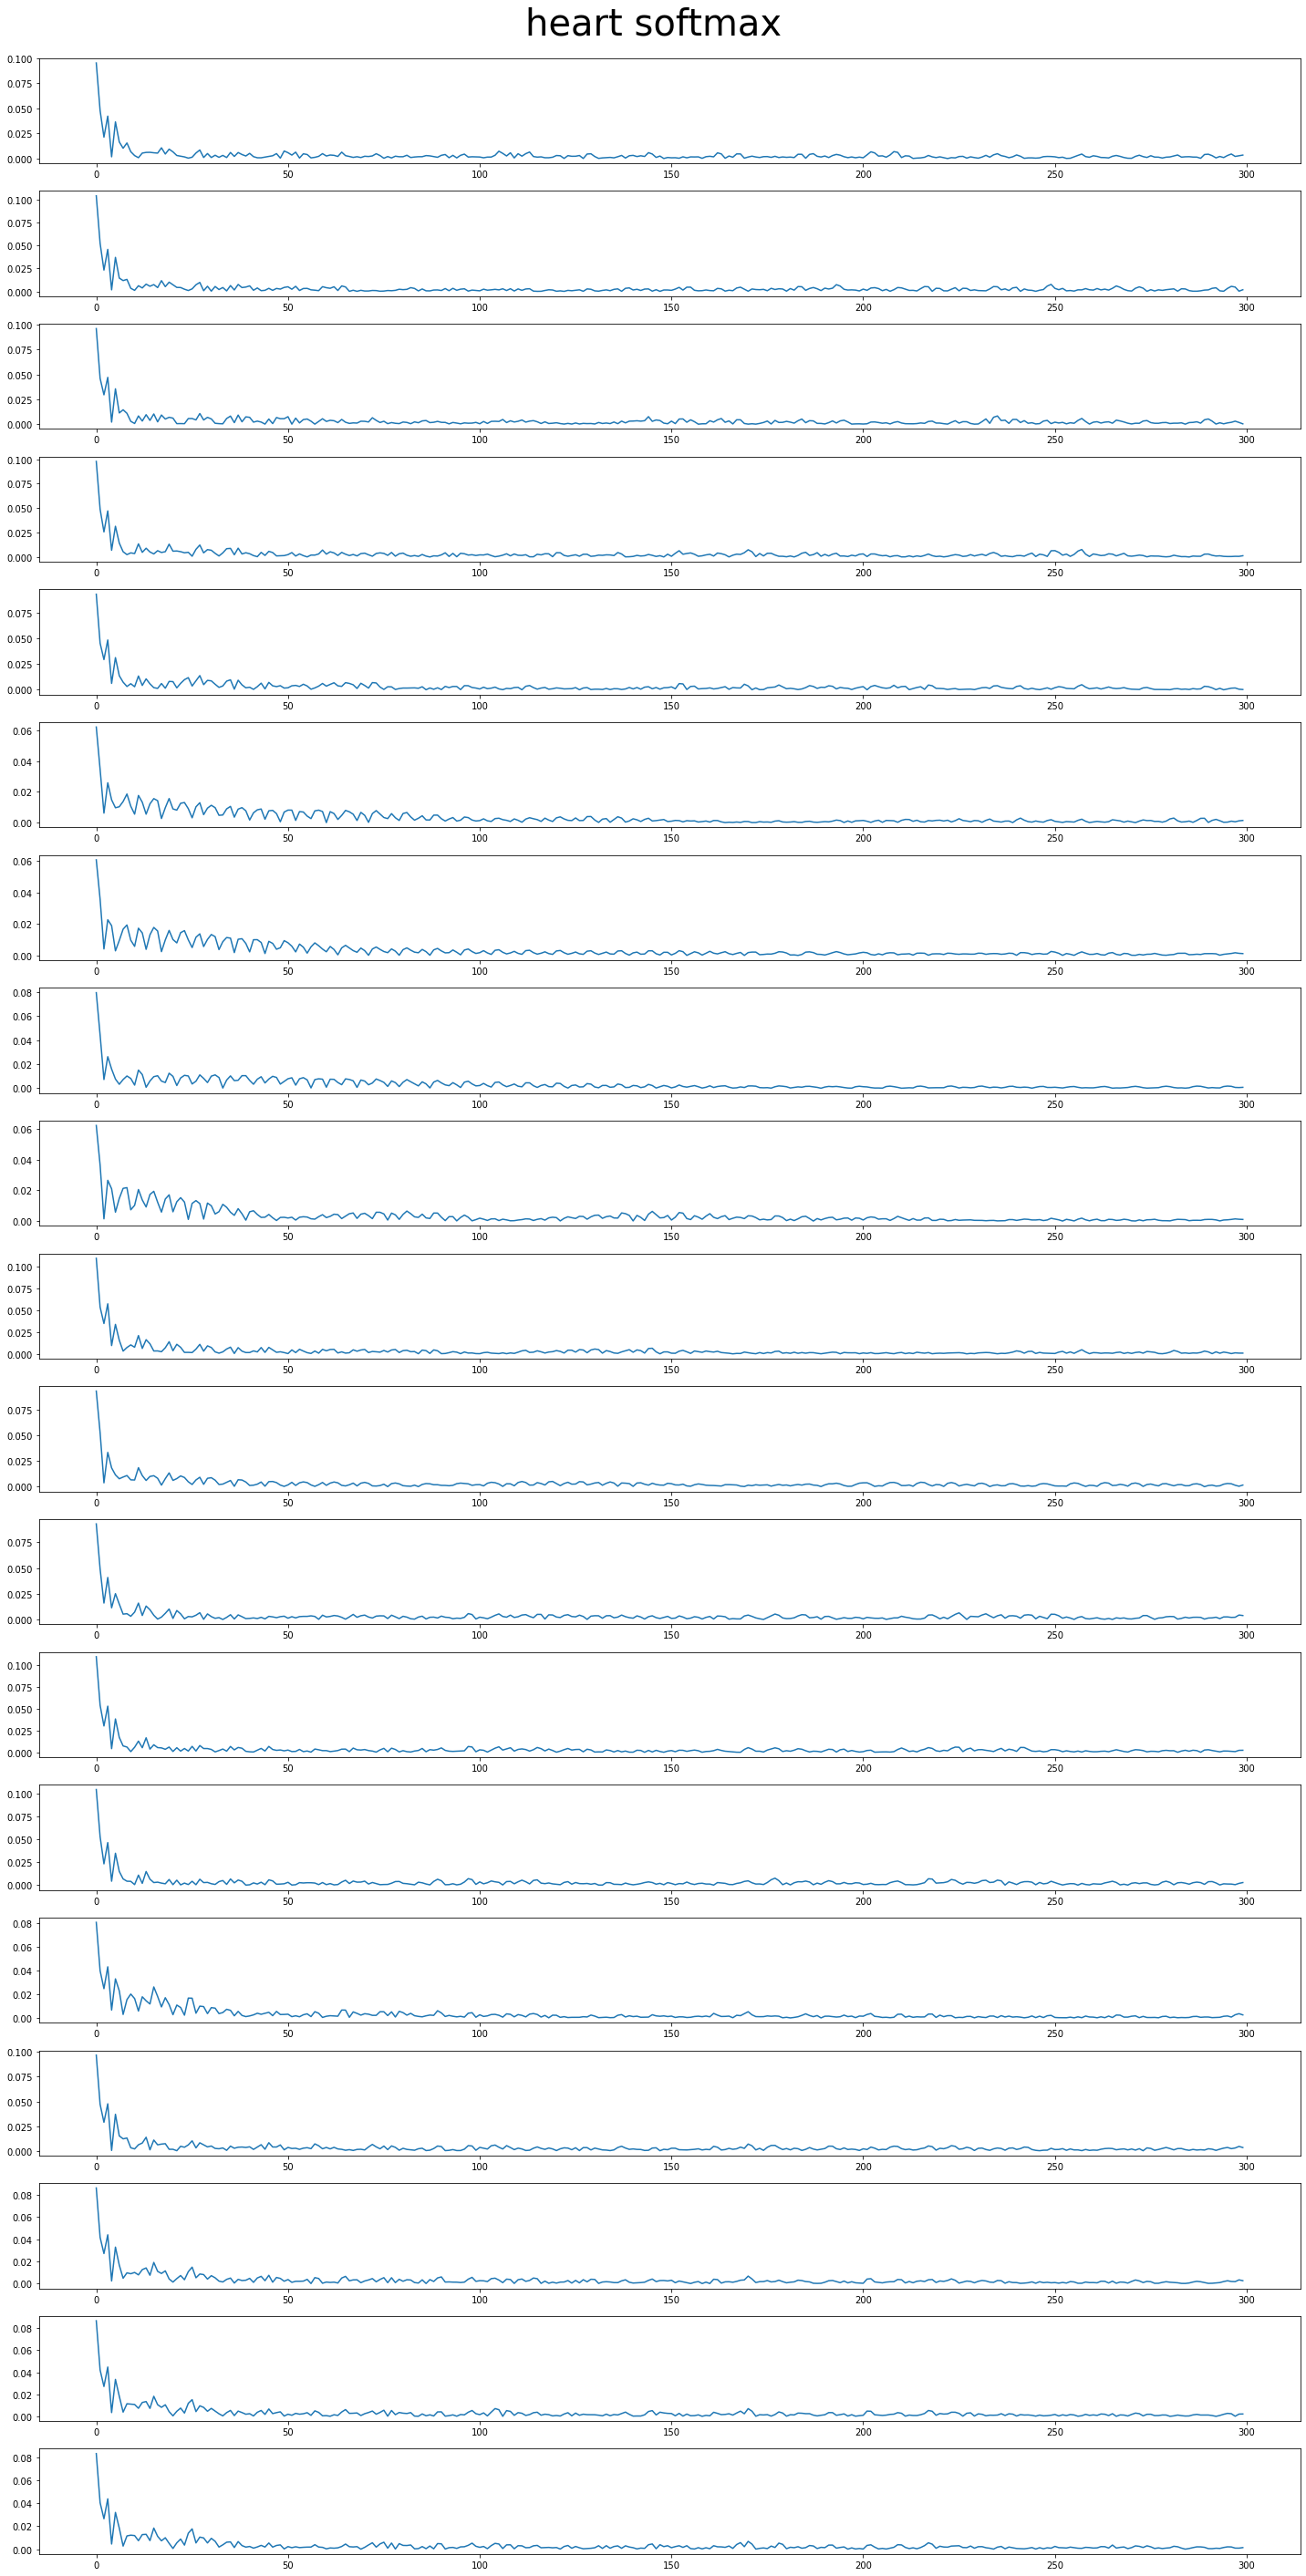

In [28]:
if (_DRAW_SOFTMAX):
    # 畫出分布
    draw_target_ = heart_logscale_softmax

    fig, axs = plt.subplots(draw_target_.shape[0])

    fig.set_figheight(40)
    fig.set_figwidth(20)

    for i in range(draw_target_.shape[0]):
        axs[i].plot(draw_target_[i][:])
    fig.suptitle("heart softmax",size=40)
    fig.tight_layout()
    fig.subplots_adjust(top=0.96)
    

In [38]:
def KL(P,Q):
    epsilon =  np.finfo(float).eps

    P = P+epsilon
    Q = Q+epsilon

    divergence = np.sum(P*np.log(P/Q))
    return divergence

In [48]:
ll = __lung_data__['logscale_softmax']
hh = __heart_data__['logscale_softmax']
print("logscale KL divergence:")
print("KL( heart | lung )={:7f}".format(np.mean([KL(l,h) for l,h in zip(ll,hh)])))
print("KL( lung | heart )={:7f}".format(np.mean([KL(h,l) for l,h in zip(ll,hh)])))

logscale KL divergence:
KL( heart | lung )=0.405475
KL( lung | heart )=0.433806
